# Desafio  Cientista de Dados

## Descrição do desafio

Você foi alocado em um time da Indicium contratado por um estúdio de Hollywood chamado PProductions, e agora deve fazer uma análise em cima de um banco de dados cinematográfico para orientar qual tipo de filme deve ser o próximo a ser desenvolvido. Lembre-se que há muito dinheiro envolvido, então a análise deve ser muito detalhada e levar em consideração o máximo de fatores possíveis (a introdução de dados externos é permitida - e encorajada).


## 1. Análise exploratória dos dados

### 1.1 Preparação do ambiente

Import dos pacotes e bibliotecas necessários.

In [1]:
# biblitecas para análise de dados
import pandas as pd
import numpy as np
from collections import Counter

# Bibliotecas para gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Biblioteca para processamento de linguagem natural
import spacy

# Datetime
from datetime import datetime as dt

# Pacotes de machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Biblioteca para exportar e carregar arquivo pickle
import joblib

nlp = spacy.load("en_core_web_sm")

Leitura dos dados

In [2]:
df = pd.read_csv('desafio_indicium_imdb.csv')

### 1.2 Tratamento dos dados

#### 1.2.1 Identificação de tratamento de valores nulos

Visualização das informações básicas do dataframe.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [4]:
df.describe()

,Unnamed: 0,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,999.000000,842.000000,9.990000e+02
mean,500.000000,7.947948,77.969121,2.716214e+05
std,288.530761,0.272290,12.383257,3.209126e+05
min,1.000000,7.600000,28.000000,2.508800e+04
25%,250.500000,7.700000,70.000000,5.547150e+04
50%,500.000000,7.900000,79.000000,1.383560e+05
75%,749.500000,8.100000,87.000000,3.731675e+05
max,999.000000,9.200000,100.000000,2.303232e+06


Vemos que o dataset tem 99 linhas e 15 colunas. A coluna 'Unnamed:0' é uma coluna com IDs únicos para cada filme e poderá ser removida da análise sem prejuízos.

As colunas Meta_score e Gross têm valores nulos. Como não há uma forma direta de preencher os valores nulos nessas colunas e considerando que o percentual de nulos fica em torno de 16%, será optado por remover os campos nulos da análise.

In [5]:
# Remoção da coluna Unnamend: 0
df.drop(columns=['Unnamed: 0'], inplace=True)

# Remoção de valores nulos
df.dropna(inplace=True)


# Info do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    object 
 2   Certificate    713 non-null    object 
 3   Runtime        713 non-null    object 
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 89.1+ KB


Ao final desse tratamento, ficamos com 713 filmes, o que representa um percentual de 71,37% do total original.

#### 1.2.2 Correção do formato da coluna Gross

Ainda temos que a coluna Gross, que representa o faturamento dos filmes, está como tipo `object`. Precisamos tratar essa coluna para que fique em um formato numérico.

In [6]:
df['Gross'].head(10)

0    134,966,411
1    534,858,444
2     57,300,000
3      4,360,000
4    377,845,905
5    107,928,762
6     96,898,818
7    292,576,195
8     37,030,102
9    315,544,750
Name: Gross, dtype: object

O motivo da má interpretação dos valores na coluna Gross é que foram utilizadas vírgulas para a representação de milhares. Vamos, a seguir, converter esses valores para o tipo correto.

In [7]:
df['Gross'] = df['Gross'].str.replace(',', '').astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    object 
 2   Certificate    713 non-null    object 
 3   Runtime        713 non-null    object 
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 89.1+ KB


#### 1.2.3 Correção do formato da coluna Released_Year

Verifiquemos os valores únicos da coluna Release_Year para entender o motivo de ela ser reconhecida como `object` ao invés de um tipo numérico.

In [8]:
df['Released_Year'].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2019',
       '2014', '1998', '1997', '1995', '1991', '1977', '1954', '2011',
       '2006', '2000', '1988', '1985', '1968', '1960', '1942', '1936',
       '1931', '2018', '2016', '2017', '2012', '2009', '1981', '1979',
       '1964', '2004', '1992', '1987', '1986', '1984', '1983', '1976',
       '1973', '1971', '1965', '1962', '1959', '1958', '1952', '1944',
       '1941', '2013', '2007', '2005', '1989', '1963', '1950', '1948',
       '2015', '1996', '1982', '1978', '1967', '1951', '1949', '1940',
       '1939', '1934', '1970', '1969', '1961', '1946', '1930', '1938',
       '1933', 'PG', '1953'], dtype=object)

Vemos que, ao menos um registro tem o valor PG como Release_Year. A seguir, vamos conferir quais são esses registros.

In [9]:
df.query('Released_Year == "PG"')

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933.0


Como temos apenas um filme, é fácil pesquisarmos qual o ano de lançamento do mesmo para fazer o preenchimento do valor correto. O filme em questão foi lançado em 1995. A seguir, será feita a correção do ano de lançamento.

In [10]:
df.loc[965, 'Released_Year'] = 1995
df.query('Series_Title == "Apollo 13"')

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,1995,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933.0


Agora podemos fazer a conversão do tipo de dado da coluna Release_Year para o tipo correto.

In [11]:
df['Released_Year'] = df['Released_Year'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Certificate    713 non-null    object 
 3   Runtime        713 non-null    object 
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(2), object(10)
memory usage: 105.3+ KB


#### 1.2.4 Remoção do texto min da coluna Runtime

A coluna Runtime tem a terminação " min" para indicar a duração dos filmes. Vamos removê-la, pois isso facilita a manipulação e o uso desses dados para modelos futuros.

In [12]:
df['Runtime'] = df['Runtime'].str.removesuffix(' min').astype(int)

# Renomeando coluna Runtime para incluir a informação de min no head da mesma
df.rename(columns={'Runtime':'Runtime_min'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Certificate    713 non-null    object 
 3   Runtime_min    713 non-null    int64  
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 105.3+ KB


#### 1.2.5 Tratamento da coluna Genre

Vejamos o conteúdo da coluna Genre

In [13]:
df['Genre'].unique()

array(['Crime, Drama', 'Action, Crime, Drama', 'Action, Adventure, Drama',
       'Biography, Drama, History', 'Action, Adventure, Sci-Fi', 'Drama',
       'Drama, Romance', 'Western', 'Action, Sci-Fi',
       'Biography, Crime, Drama', 'Action, Adventure, Fantasy',
       'Comedy, Drama, Thriller', 'Adventure, Drama, Sci-Fi',
       'Animation, Adventure, Family', 'Drama, War',
       'Crime, Drama, Fantasy', 'Comedy, Drama, Romance',
       'Crime, Drama, Mystery', 'Crime, Drama, Thriller', 'Drama, Music',
       'Biography, Comedy, Drama', 'Drama, Mystery, Sci-Fi',
       'Biography, Drama, Music', 'Crime, Mystery, Thriller',
       'Animation, Adventure, Drama', 'Adventure, Comedy, Sci-Fi',
       'Horror, Mystery, Thriller', 'Drama, Romance, War',
       'Comedy, Drama, Family', 'Animation, Drama, Fantasy',
       'Animation, Action, Adventure', 'Drama, Western',
       'Action, Adventure', 'Comedy, Drama', 'Drama, Mystery, Thriller',
       'Action, Drama, Mystery', 'Mystery, Thr

Vemos que um filme pode ser classificado em diferentes gêneros. A listagem mostra que os filmes foram classificados, cada um, em até três gêneros diferentes.

Vamos verificar a seguir o total de combinações únicas.

In [14]:
df['Genre'].nunique()

172

Temos um total de 172 combinações. Vamos separar essa coluna em novas colunas.

In [15]:
df[['Genre_1', 'Genre_2', 'Genre_3']] = df['Genre'].str.split(', ', expand=True)

df.head()

,Series_Title,Released_Year,Certificate,Runtime_min,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Genre_1,Genre_2,Genre_3
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,Crime,Drama,None
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,Action,Crime,Drama
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,Crime,Drama,None
3,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,Crime,Drama,None
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,Action,Adventure,Drama


Lista de gêneros únicos do dataset.

In [16]:
set(df['Genre_1'].unique().flatten()) | set(df['Genre_2'].unique().flatten()) | set(df['Genre_3'].unique().flatten()) 

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 None,
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

Total de gêneros únicos do dataset.

In [17]:
len(set(df['Genre_1'].unique().flatten()) | set(df['Genre_2'].unique().flatten()) | set(df['Genre_3'].unique().flatten()) )

22

Com um menor número de gêneros para classificar os filmes, fica melhor analisá-los e agrupá-los futuramente.

Agora não precisamos mais da coluna Genre.

In [18]:
df.drop(columns='Genre', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Certificate    713 non-null    object 
 3   Runtime_min    713 non-null    int64  
 4   IMDB_Rating    713 non-null    float64
 5   Overview       713 non-null    object 
 6   Meta_score     713 non-null    float64
 7   Director       713 non-null    object 
 8   Star1          713 non-null    object 
 9   Star2          713 non-null    object 
 10  Star3          713 non-null    object 
 11  Star4          713 non-null    object 
 12  No_of_Votes    713 non-null    int64  
 13  Gross          713 non-null    float64
 14  Genre_1        713 non-null    object 
 15  Genre_2        638 non-null    object 
 16  Genre_3        478 non-null    object 
dtypes: float64(3), int64(3), object(11)
memory usage: 116.4+ KB

### 1.3 Análise exploratória

#### 1.3.1 Filmes de maior bilheteria

In [19]:
df.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime_min',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Genre_1', 'Genre_2',
       'Genre_3'],
      dtype='object')

/tmp/ipykernel_9620/1051497374.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(xlabels)


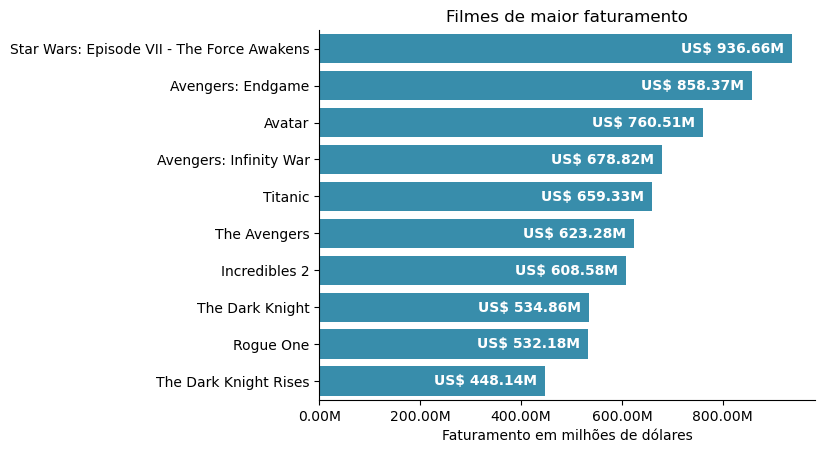

In [20]:
df_top10_faturamento = df.sort_values(by='Gross', ascending=False).head(10)

chart = sns.barplot(data=df_top10_faturamento, y='Series_Title', x='Gross', color='#2596be')
plt.ylabel('')
plt.xlabel('Faturamento em milhões de dólares')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in chart.get_xticks()/1_000_000]
chart.set_xticklabels(xlabels)
plt.title('Filmes de maior faturamento')
sns.despine()
chart.bar_label(chart.containers[0], 
                labels=[f'US$ {x:,.2f}M' for x in round(df_top10_faturamento['Gross']/1_000_000, 2)],
                padding=-80, color='white', weight='bold')
plt.show()

Gêneros dos filmes de maior faturamento.

In [21]:
df_top10_faturamento['Genre_1'].value_counts(), df_top10_faturamento['Genre_2'].value_counts()

(Genre_1
 Action       8
 Drama        1
 Animation    1
 Name: count, dtype: int64,
 Genre_2
 Adventure    7
 Romance      1
 Action       1
 Crime        1
 Name: count, dtype: int64)

Os resultados nos mostram que, para esta amostra, os filmes de maior faturamento são aqueles cujo gênero principal é ação. O gráfico acima mostra que atualmente os filmes de maior faturamento são os de heróis, principalmente os dos estúdios Marvel. Portanto, considerando esses números, parece interessante investir nesses gêneros de filmes produzidos por esse estúdio.

#### 1.3.2 Filmes por público

Podemos avaliar o sucesso dos filmes também pelo número de votos recebidos. Vamos analisar a relação entre votos, avaliação e faturamento dos filmes.

In [22]:
df.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime_min',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Genre_1', 'Genre_2',
       'Genre_3'],
      dtype='object')

/tmp/ipykernel_9620/366466354.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(xlabels)


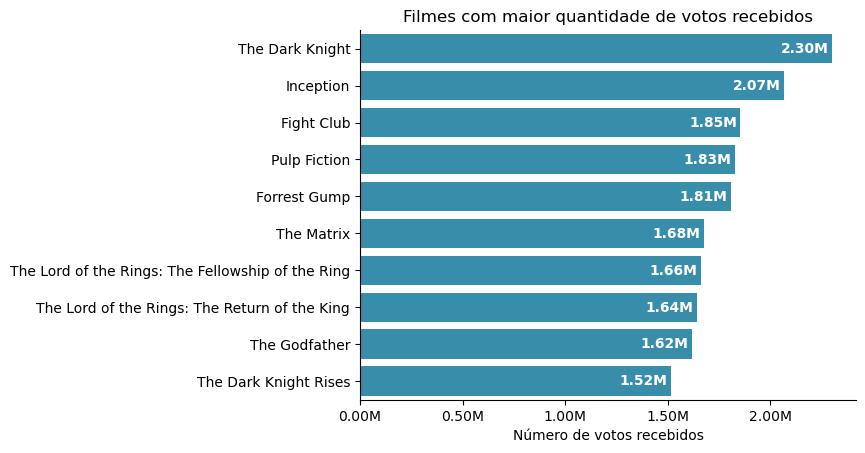

In [23]:
# Seleção dos 10 filmes com maior número de votos
df_top10_votos = df.sort_values(by='No_of_Votes', ascending=False).head(10)

chart = sns.barplot(data=df_top10_votos, y='Series_Title', x='No_of_Votes', color='#2596be')
plt.ylabel('')
plt.xlabel('Número de votos recebidos')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in chart.get_xticks()/1_000_000]
chart.set_xticklabels(xlabels)
plt.title('Filmes com maior quantidade de votos recebidos')
sns.despine()
chart.bar_label(chart.containers[0], 
                labels=[f'{x:,.2f}M' for x in round(df_top10_votos['No_of_Votes']/1_000_000, 2)],
                padding=-37, color='white', weight='bold')
plt.show()


Observamos que os filmes com maior quantidade de votos aqui não são os de maior faturamento. Embora despertem interesse do público e sejam avaliados, não conseguem ter o mesmo faturamento das grandes produções. Vamos analisar a seguir o desempenho deles em relação às notas obtidas.

Text(0.0, 1.0, 'Notas dos filmes de maior faturamento')

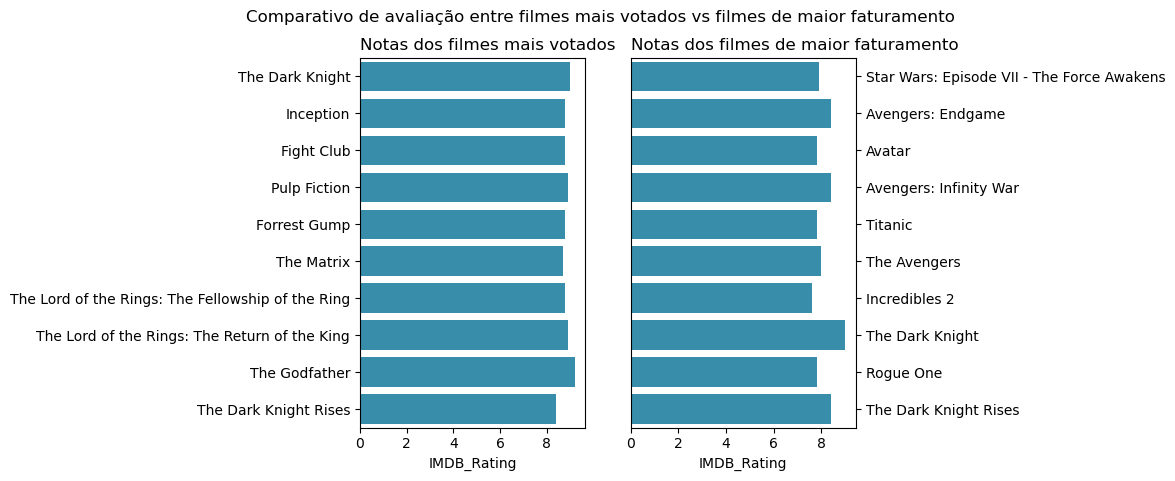

In [24]:
fig, axes = plt.subplots(1, 2)
sns.barplot(data=df_top10_votos, y='Series_Title', x='IMDB_Rating', color='#2596be', ax=axes[0])
sns.barplot(data=df_top10_faturamento, y='Series_Title', x='IMDB_Rating', color='#2596be', ax=axes[1])
axes[1].yaxis.tick_right()
axes[0].set_ylabel('')
axes[1].set_ylabel('')
plt.suptitle('Comparativo de avaliação entre filmes mais votados vs filmes de maior faturamento')
axes[0].set_title('Notas dos filmes mais votados', loc='left')
axes[1].set_title('Notas dos filmes de maior faturamento', loc='left')

In [25]:
print('Avaliação média dos filmes mais avaliados = {:.2f}'.format(df_top10_votos['IMDB_Rating'].mean()))
print('Avaliação média dos filmes de maior faturamento = {:.2f}'.format(df_top10_faturamento['IMDB_Rating'].mean()))

Avaliação média dos filmes mais avaliados = 8.83
Avaliação média dos filmes de maior faturamento = 8.11


Ambos os conjuntos de filmes são bem avaliados, com média acima de 8. No entanto, os filmes mais avaliados têm média quase 9 e também apresentam maior uniformidade nos resultados. Observa-se que há maior variabilidade entre as notas dos filmes de maior faturamento do que nos mais avaliados. Isso mostra que, embora faturem menos e alcancem um público menor, os filmes mais avaliados costumam agradar mais ao seu público. Além disso, como geralmente não são produções mais caras, franquias nesses estilos podem satisfazer mais seu público-alvo e garantir um retorno proporcionalmente maior para os investidores.

In [26]:
df_top10_votos['Genre_1'].value_counts(), df_top10_votos['Genre_2'].value_counts()

(Genre_1
 Action    6
 Drama     2
 Crime     2
 Name: count, dtype: int64,
 Genre_2
 Adventure    4
 Drama        2
 Crime        1
 Romance      1
 Sci-Fi       1
 Name: count, dtype: int64)

Neste grupo, observamos maior dispersão de gêneros. Embora a maioria ainda seja de Ação e Aventura, agora há uma maior presença de filmes do gênero Drama. Além disso, começam a surgir gêneros como Romance e Sci-Fi.

#### 1.3.3 Número de lançamentos

A partir da coluna Released_Year, podemos observar a evolução dos gêneros mais populares ao longo do tempo.

Primeiramente, vamos verificar o número de lançamentos por gênero principal a cada ano.

In [27]:
filmes_por_ano_genero = df.groupby(['Released_Year', 'Genre_1']).size().reset_index(name='count')
filmes_por_ano_genero

,Released_Year,Genre_1,count
0,1930,Drama,1
1,1931,Comedy,1
2,1933,Adventure,1
3,1934,Comedy,1
4,1936,Comedy,1
...,...,...,...
338,2019,Animation,1
339,2019,Biography,1
340,2019,Comedy,5
341,2019,Crime,1


/home/duartejr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/duartejr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


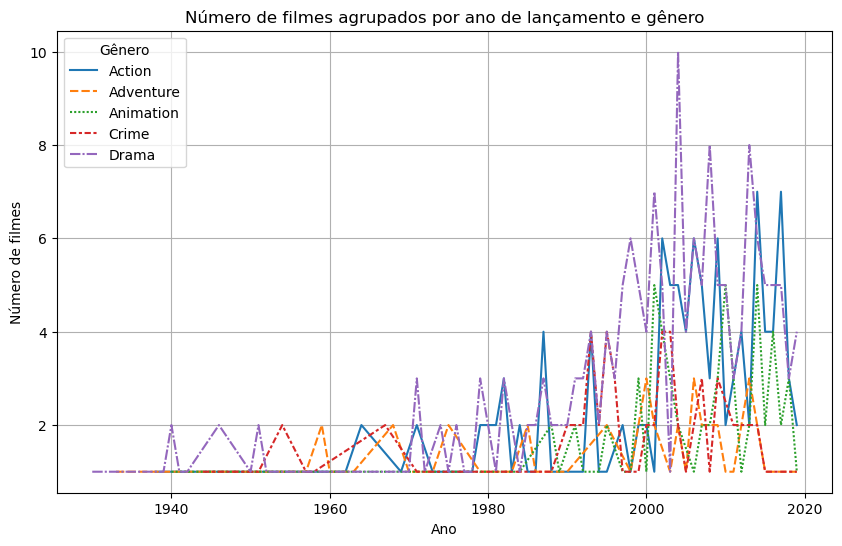

In [28]:
pivot_df = filmes_por_ano_genero.pivot(index='Released_Year', columns='Genre_1', values='count').fillna(0)
pivot_df = pivot_df.replace(0, np.NAN)

# Seleção dos gêneros que mais apareceram nas análises anteriores
pivot_df = pivot_df[['Action', 'Adventure', 'Animation', 'Crime', 'Drama']]

plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_df)
plt.title('Número de filmes agrupados por ano de lançamento e gênero')
plt.xlabel('Ano')
plt.ylabel('Número de filmes')
plt.legend(title='Gênero')
plt.grid(True)
plt.show()

Observamos que até os anos 2000 há poucos lançamentos registrados no dataset. Vamos então focar esta análise somente no período a partir de 2020. No gráfico a seguir, faremos a seleção apenas para esse período.

/home/duartejr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/duartejr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


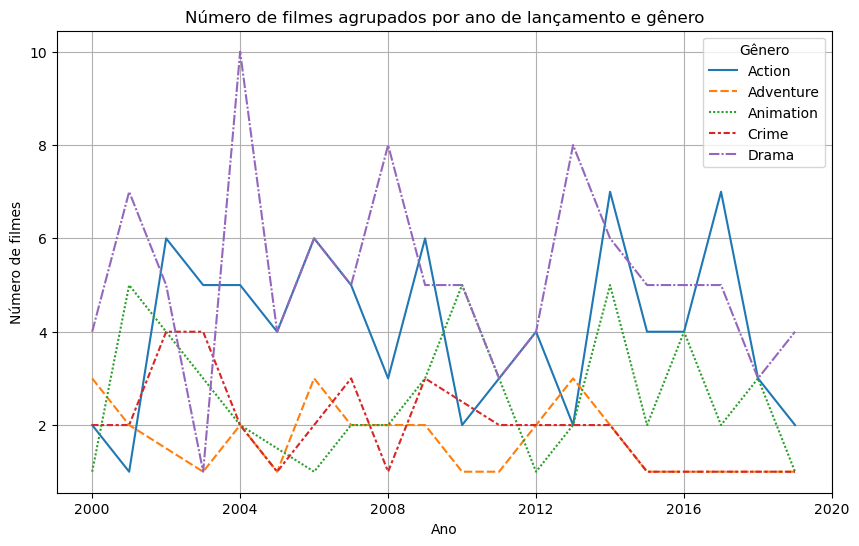

In [29]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_df.query('Released_Year >= 2000'))
plt.title('Número de filmes agrupados por ano de lançamento e gênero')
plt.xlabel('Ano')
plt.xticks(range(2000, 2021, 4))
plt.ylabel('Número de filmes')
plt.legend(title='Gênero')
plt.grid(True)
plt.show()

Agora podemos ver melhor o número de lançamentos nos últimos anos. O gênero Drama teve seu ápice em 2004, mas a partir de 2013 apresentou um declínio constante. Os filmes de Ação têm um número de lançamentos por ano bastante semelhante, mantendo seus patamares desde 2002. Já os filmes de Animação, após um período de poucos lançamentos (de 2004 a 2012), tiveram um aumento significativo no número de produções a partir de 2014.

Vamos agora analisar os acumulados no período.

In [30]:
pivot_df.query('Released_Year >= 2000').sum(axis=0).sort_values(ascending=False)

Genre_1
Drama        103.0
Action        81.0
Animation     44.0
Crime         34.0
Adventure     29.0
dtype: float64

Agora vemos que, mesmo com seu declínio recente, os dramas são os filmes mais produzidos neste dataset, seguidos pelos filmes de ação. Portanto, investir em filmes desses gêneros, considerando sua popularidade, pode ser uma boa alternativa. Filmes de animação também têm um bom potencial devido ao crescimento recente no número de lançamentos anuais, mostrando-se como um segmento promissor, embora ainda necessite de mais análise para confirmar essa tendência.

## 2. Questões levantadas pela equipe da Indicium

### 2.1 Qual filme você recomendaria para uma pessoa que você não conhece?


Recomendaria os filmes com melhor avaliação, mas selecionaria primeiro aqueles com maior número de avaliações e maior bilheteria. Isso porque filmes muito bem avaliados, mas com poucos votos ou baixa bilheteria, geralmente são filmes de nicho que não são tão populares e podem não agradar a uma grande parte do público.

Primeiramente, vamos verificar a distribuição de votos no dataset para entender o que seria considerado um filme com poucos votos em nossa amostra.

In [31]:
round(df['No_of_Votes'].describe(), 2)

count        713.00
mean      353348.04
std       346221.17
min        25229.00
25%        95826.00
50%       236311.00
75%       505918.00
max      2303232.00
Name: No_of_Votes, dtype: float64

Pela distribuição de votos apresentada, vemos que 50% dos filmes têm 138.356 votos ou menos. Já os 25% mais populares (terceiro quartil) têm mais de 373.167,50 votos. Portanto, posso considerar que filmes mais populares tenham mais de 300.000 votos para facilitar os cálculos.

In [32]:
df_melhores = df[df['No_of_Votes'] >= 300_000]
df_melhores.shape

(300, 17)

Ainda estamos com mais de trezentos filmes para indicar. O próximo critério que será adotado é o faturamento da bilheteria, pois essa variável está diretamente relacionada com o número de espectadores do filme.

In [33]:
round(df_melhores['Gross'].describe(), 0)

count          300.0
mean     142189422.0
std      143015231.0
min         269061.0
25%       40134046.0
50%      100165950.0
75%      209946952.0
max      936662225.0
Name: Gross, dtype: float64

Da mesma forma que no passo anterior, vou selecionar aproximadamente os 25% com maior faturamento. No caso, serão os filmes com faturamento superior a 200.000.000.

In [34]:
df_melhores = df_melhores[df_melhores['Gross'] >= 200_000_000]
df_melhores.shape

(82, 17)

Ficaram agora apenas 82 filmes. Agora vou selecionar os 5 filmes com as melhores notas para serem a recomendação.

In [35]:
df_melhores.sort_values(by='IMDB_Rating', ascending=False).head(5)

,Series_Title,Released_Year,Certificate,Runtime_min,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Genre_1,Genre_2,Genre_3
1,The Dark Knight,2008,UA,152,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,Action,Crime,Drama
4,The Lord of the Rings: The Return of the King,2003,U,201,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,Action,Adventure,Drama
7,Inception,2010,UA,148,8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292576195.0,Action,Adventure,Sci-Fi
9,The Lord of the Rings: The Fellowship of the Ring,2001,U,178,8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750.0,Action,Adventure,Drama
10,Forrest Gump,1994,UA,142,8.8,"The presidencies of Kennedy and Johnson, the e...",82.0,Robert Zemeckis,Tom Hanks,Robin Wright,Gary Sinise,Sally Field,1809221,330252182.0,Drama,Romance,None


Finalizamos com 5 filmes. Cada um com nota (IMDB_Rating) superior a 8, mais de 1.000.000 de avaliações cada e faturamento superior a 300.000.000. Portanto, filmes de sucesso em público e crítica.

### 2.2 Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Com o dataset disponível podemos começar pela correlação entre as variáveis numéricas.

In [36]:
# Calculando correlação
matriz_correlacao = df[['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']].corr()

# Formatando a tabela com cores
matriz_correlacao = matriz_correlacao.style.background_gradient(cmap='coolwarm')

# Exibindo tabela
matriz_correlacao

,IMDB_Rating,Meta_score,No_of_Votes,Gross
IMDB_Rating,1.000000,0.283745,0.609239,0.130857
Meta_score,0.283745,1.000000,0.028578,-0.014663
No_of_Votes,0.609239,0.028578,1.000000,0.560955
Gross,0.130857,-0.014663,0.560955,1.000000


A tabela nos mostra uma forte correlação positiva entre No_of_Votes e Gross. Isso reflete o fato de que quanto maior o número de público, maior a quantidade de espectadores que irão votar no filme. Também podemos observar algo interessante: há uma correlação positiva entre No_of_Votes e a nota IMDB_Rating, o que indica que os espectadores mais interessados em avaliar um filme nessa plataforma são também aqueles que tiveram as melhores experiências com os filmes.

Outro fator ligado ao faturamento são as estrelas e diretores dos filmes. Vejamos a seguir o faturamento médio por Diretores.

In [37]:
round(df.groupby('Director')['Gross'].mean().sort_values(ascending=False), 0)

Director
Anthony Russo           551259851.0
Gareth Edwards          532177324.0
J.J. Abrams             474390302.0
Josh Cooley             434038008.0
Roger Allers            422783777.0
                           ...     
Troy Duffy                  25812.0
Joseph L. Mankiewicz        10177.0
José Padilha                 8060.0
Jaco Van Dormael             3600.0
Anders Thomas Jensen         1305.0
Name: Gross, Length: 402, dtype: float64

Portanto vemos que filmes dirigidos por: Anthony Russo, Gareth Edwards, J. J. Abrams, Josh Cooley e Roger Allers, têm os maiores faturamentos médios.

Vejamos também o faturamento médio pela estrela principal.

In [38]:
round(df.groupby('Star1')['Gross'].mean().sort_values(ascending=False), 0)

Star1
Daisy Ridley            936662225.0
Sam Worthington         760507625.0
Joe Russo               551259851.0
Felicity Jones          532177324.0
Henry Thomas            435110554.0
                           ...     
Alejandro Jodorowsky        61001.0
Willem Dafoe                25812.0
Ray Milland                 12562.0
Wagner Moura                 8060.0
Jared Leto                   3600.0
Name: Gross, Length: 471, dtype: float64

E agora temos uma lista das estrelas principais com os filmes de maior faturamento médio.

Com base nessas informações, podemos esperar que filmes dirigidos por um dos diretores listados como top e estrelados por uma das principais estrelas tenham faturamentos mais altos.

### 2.3 Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Podemos aplicar uma técnica de NLP para extrair as principais palavras do overview e então ter uma noção dos temas principais de cada filme. A técnica que escolhi para realizar esse procedimento é a TF-IDF. Vamos ver a implementação dela.

In [39]:
# Pré-processamento de texto: Remover stopwords, pontuações e transformar em minúsculas
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    
    doc = nlp(text)
    cleaned_text = [token.lemma_ for token in doc]
    
    return ' '.join(cleaned_text)

df['Cleaned_Overview'] = df['Overview'].apply(clean_text)

# Aplicar TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=150)
tfidf_matrix = vectorizer.fit_transform(df['Cleaned_Overview'])

# Extrair palavras-chave com maiores pontuações TF-IDF
def get_top_keywords(tfidf_matrix, vectorizer, top_n=5):
    keywords = []
    for row in tfidf_matrix:
        sorted_indices = np.argsort(row.toarray()).flatten()[::-1]
        feature_names = vectorizer.get_feature_names_out()
        top_keywords = [feature_names[idx] for idx in sorted_indices[:top_n]]
        keywords.append(top_keywords)
    return keywords

df['Keywords'] = get_top_keywords(tfidf_matrix, vectorizer)

# Mostrar as primeiras linhas do dataframe com palavras-chave
print(df[['Series_Title', 'Overview', 'Keywords']].head())


                                    Series_Title  \
0                                  The Godfather   
1                                The Dark Knight   
2                         The Godfather: Part II   
3                                   12 Angry Men   
4  The Lord of the Rings: The Return of the King   

                                            Overview  \
0  An organized crime dynasty's aging patriarch t...   
1  When the menace known as the Joker wreaks havo...   
2  The early life and career of Vito Corleone in ...   
3  A jury holdout attempts to prevent a miscarria...   
4  Gandalf and Aragorn lead the World of Men agai...   

                               Keywords  
0         [age, crime, son, form, girl]  
1  [know, people, fight, young, friend]  
2      [career, crime, york, city, son]  
3    [attempt, force, form, good, girl]  
4        [army, lead, world, man, form]  


Contagem das palavras mais comuns

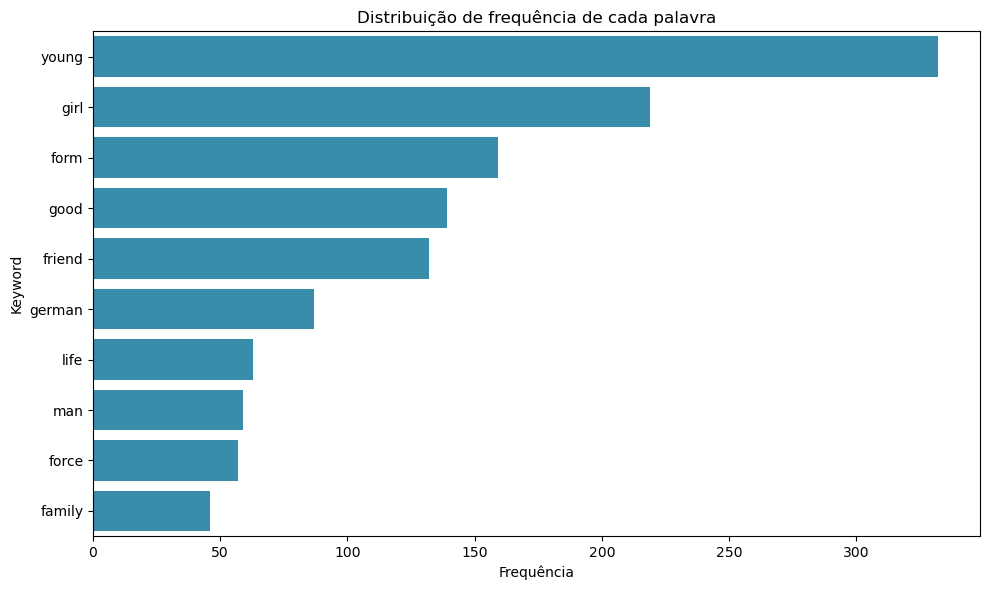

In [40]:
# Transformar Series em List para facilitar a contagem da ocorrência de palavras.
keywords = df['Keywords'].tolist()

# Converte a lista de listas em uma lista única
if isinstance(keywords[0], list):
    keywords = [item for sublist in keywords for item in sublist]

# Cria um dicionário para contagem da ocorrência de cada palavras
word_counts = Counter(keywords)

# Organizar as palavras em ordem decrescente de frequência
sorted_word_counts = word_counts.most_common()

# Cria um dataframes com as palavras ordenadas e seleciona as 10 mais comuns
word_count_df = pd.DataFrame(sorted_word_counts, columns=['Keyword', 'Frequency'])[:10]

# Gráfico de barras para exibição das palavras mais comuns
plt.figure(figsize=(10, 6))  
sns.barplot(data=word_count_df, x='Frequency', y='Keyword', color='#2596be')
plt.xlabel('Frequência')
plt.title('Distribuição de frequência de cada palavra')
plt.tight_layout()
plt.show()


Essa análise nos permitiu identificar as palavras mais comuns nos resumos dos filmes. Através da análise detalhada dessas palavras, é possível identificar um contexto geral do estilo de cada filme, mas isso demandaria uma análise individual para cada filme. Considerando o tempo disponível, não é viável aplicar aqui. Também poderia ser criado um modelo de machine learning que associasse a descrição do filme a um estilo.

In [41]:
word_count_df['Keyword'].unique()

array(['young', 'girl', 'form', 'good', 'friend', 'german', 'life', 'man',
       'force', 'family'], dtype=object)

## 3. Modelo de previsão das notas do IMDB

### 3.1 Explique como você faria a previsão da nota do IMDB a partir dos dados.

Através da análise exploratória dos dados ao longo deste desafio, pudemos identificar algumas variáveis úteis para estimar a nota de um filme. O tratamento realizado nos dados já permitiu que algumas variáveis estejam em seus formatos adequados. Pela correlação, vimos que No_of_Votes tem uma forte relação com a nota do filme. Também identificamos que o Diretor e a Estrela principal influenciam na avaliação do filme. Portanto, já temos algumas variáveis com forte relação com a nota final do filme, sugerindo serem boas preditoras dessa métrica.

Após a análise exploratória inicial, podemos explorar mais a correlação entre as variáveis e a nota final do filme. O tratamento feito na coluna Overview também é interessante para o modelo, pois agora podemos utilizar uma pequena quantidade de palavras para extrair os temas principais dos filmes, o que pode ser útil na composição da nota final.

Com esses tratamentos realizados, o próximo passo é dividir o conjunto de dados em bases de treino e teste. Infelizmente, temos uma amostra relativamente pequena, o que pode enviesar os resultados obtidos. Melhores resultados poderiam ser obtidos com um conjunto maior. Irei adotar uma divisão de 80/20 (80% para treinamento do modelo e 20% dos dados para teste).

Em seguida, realizaremos o teste com alguns modelos de machine learning em busca do que possa apresentar o melhor desempenho possível.

Finalmente, realizamos o fine-tuning do modelo escolhido. O fine-tuning consiste em ajustar os hiperparâmetros do modelo para obter o melhor resultado possível.

Após escolher e ajustar o modelo, iremos exportá-lo em um formato binário que permita seu uso para prever notas de novos filmes.

### 3.2 Quais variáveis e/ou suas transformações você utilizou e por quê?

O uso de algumas variáveis foi explicado na questão anterior. Aqui vou explicar mais algumas variáveis utilizadas e transformações adotadas.

Logo no início da análise exploratória, a coluna Genre foi dividida em outras três colunas (Genre_1, Genre_2, Genre_3). Isso permitiu uma melhor análise dos gêneros de cada filme, pois reduziu o número de itens únicos para avaliar. Da mesma forma, essa divisão é útil para o modelo de machine learning que será utilizado na classificação.

Em todas as colunas categóricas (Director, Star1, Star2, Star3, Star4, Genre_1, Genre_2, Genre_3), será aplicada a transformação One-Hot-Encoder. Essa é uma técnica usada para lidar com variáveis categóricas em conjuntos de dados. Ela transforma as variáveis categóricas em um formato que pode ser usado por algoritmos de machine learning, permitindo o uso dessas variáveis em modelos matemáticos. De forma simplificada, essa técnica converte os dados categóricos textuais em variáveis numéricas, facilitando seu uso em diferentes modelos de machine learning. Embora alguns modelos de machine learning sejam capazes de lidar bem com variáveis categóricas, outros necessitam que essas variáveis sejam tratadas antes de serem utilizadas no modelo.

As colunas Series_Title e Released_Year não serão consideradas. A primeira é um identificador único e, portanto, não pode ser generalizada para outros filmes. Já a Released_Year não faz muito sentido, à princípio, para avaliar um filme pelo ano de lançamento, pois o modelo construído poderá ter dificuldades em fazer previsões para anos mais recentes que não estejam na base de dados utilizada.

Nas demais colunas numéricas, será aplicada a transformação MinMaxScaler para reduzir a magnitude dos valores. Isso fará com que todas as variáveis numéricas tenham a mesma ordem de grandeza. Esse procedimento diminui o impacto que uma variável de maior magnitude possa ter, garantindo que todas as variáveis tenham inicialmente a mesma importância para a composição da nota final.

### 3.3 Qual tipo de problema estamos resolvendo (regressão, classificação)?

Como estamos tentando prever o valor de uma variável numérica contínua, estamos lidando com um problema de regressão. Embora as notas no IMDB tenham uma faixa de valores bem definida (entre 0 e 10), como é uma variável contínua, ela pode assumir qualquer valor dentro desse intervalo, caracterizando um problema de regressão.

Caso a variável fosse discreta e categórica, teríamos um problema de classificação. Por exemplo, se quiséssemos classificar um filme por estrelas, com opções de 1 a 5 estrelas sem números decimais nesse intervalo, estaríamos lidando com um problema de classificação, o que não é o nosso caso.

### 3.4  Qual medida de performance do modelo foi escolhida e por quê?

Como estamos lidando com um problema de regressão, devemos utilizar métricas como Erro Médio Absoluto (MAE), Erro Médio Quadrático (RMSE), R² ou Erro Mediano.

Primeiramento vejamos a distribuição das notas no IMDB.

/home/duartejr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


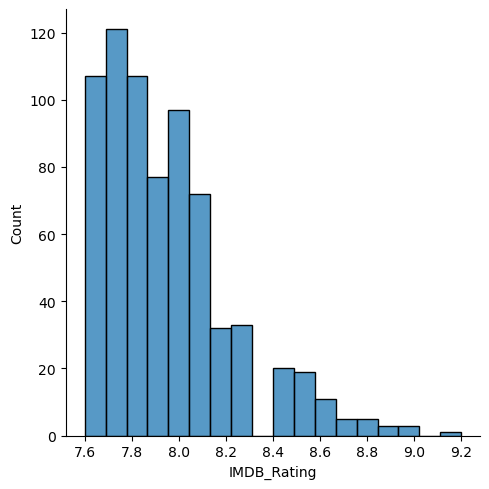

In [42]:
sns.displot(data=df, x='IMDB_Rating')

Vemos que há assimetria positiva na série, com poucos outliers e sem a presença de valores abaixo de 7.6. Portanto, podemos avaliar o modelo com: MAE e MAPE.

**Erro Absoluto Médio (MAE)**: Mede a média das diferenças absolutas entre os valores preditos e os valores reais. É menos sensível a valores extremos em comparação com o Erro Quadrático Médio (MSE).

**Erro Médio Percentual Absoluto (MAPE)**: Mede a média dos erros percentuais absolutos. Embora possa ser influenciado por valores muito pequenos no denominador, é útil para entender o erro em termos relativos.

### 3.5 Qual modelo melhor se aproxima dos dados e quais seus prós e contras?


Para responder a esta pergunta, primeiro precisamos criar o modelo a ser utilizado.

Neste projeto, serão utilizados três modelos: Regressão Linear, Random Forest e XGBoost.

* **Regressão Linear**: A regressão linear é um modelo estatístico simples que assume uma relação linear entre as variáveis independentes (preditores) e a variável dependente (alvo). O modelo tenta ajustar uma linha reta (ou hiperplano, no caso de múltiplas variáveis) que minimiza a soma dos quadrados das diferenças entre os valores observados e os valores previstos.

* **Random Forest**: Random Forest é um modelo de ensemble baseado em múltiplas árvores de decisão. Ele treina várias árvores de decisão em diferentes subconjuntos dos dados e combina suas previsões para melhorar a precisão e controlar o overfitting.

* **XGBoost**: XGBoost (Extreme Gradient Boosting) é um modelo de boosting que cria uma série de árvores de decisão sequenciais, onde cada árvore tenta corrigir os erros da anterior. Utiliza uma técnica avançada de gradient boosting que otimiza a precisão e a eficiência computacional.

Na próxima etapa realizamos a separação dos conjuntos de treino e teste do modelo.

In [43]:
# Conjunto das variáveis independentes
X = df.drop(columns=['IMDB_Rating', 'Series_Title', 'Released_Year', 'Overview', 'Cleaned_Overview', 'Keywords'])

# Seleção da variável dependente
y = df['IMDB_Rating']

# Separação dos conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Visualização do tamanho dos conjuntos.
X_train.shape, X_test.shape

((570, 13), (143, 13))

Ficamos, portanto, com 570 amostras para treinamento e 143 para testes.

Como dito antes, as colunas categóricas e numéricas terão processamentos diferentes. Portanto, é necessário listar quais colunas são categóricas e numéricas para que os modelos consigam tratar os dados de forma adequada.

In [44]:
# Identificação das colunas categóricas e numéricas
col_categoricas = ['Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Genre_1', 'Genre_2', 'Genre_3']
col_numericas = ['Runtime_min', 'Meta_score', 'No_of_Votes', 'Gross']

# Definir os transformadores para as colunas
transformer_categoricas = OneHotEncoder(handle_unknown='ignore')
transformer_numericas = MinMaxScaler()


E seguida é criado o transformer único para os dois tipos de colunas.

In [45]:
transformer = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, col_numericas),
        ('cat', transformer_categoricas, col_categoricas)
])

Agora podemos criar uma pipeline de dados que irá aplicar as transformações desejadas nos dados e passar para o modelo de regressão desejado.

In [46]:
def make_pipeline(model):
    pipeline = Pipeline(steps=[
        ('preprocessor', transformer),
        ('model', model)
    ])
    
    return pipeline

#### Regressão Linear

Agora iremos implementar a Regressão Linear

In [47]:
def train_test_model(model):
    # Cria a pipeline com o Linear Regression
    pipeline_model = make_pipeline(model)

    # Treina o pipeline
    start = dt.now()
    pipeline_model.fit(X_train, y_train)
    train_time = (dt.now() - start).seconds
    print(f'Tempo de treinamento = {train_time} segundos')

    # Faz as previsões
    start = dt.now()
    y_pred = pipeline_model.predict(X_test)
    pred_time = (dt.now() - start).seconds
    print(f'Tempo de previsão = {pred_time} segundos')

    # Avaliação o modelo
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Erro Médio Absoluto (MAE): {mae:.3f}')

    mape = 100 * mean_absolute_percentage_error(y_test, y_pred)
    print(f'Erro Médio Percentual Absoluto (MAPE): {mape:.3f} %')

    return pipeline_model

print('Avaliação Regressão Linear:')
pipeline_lr = train_test_model(LinearRegression())

Avaliação Regressão Linear:
Tempo de treinamento = 0 segundos
Tempo de previsão = 0 segundos
Erro Médio Absoluto (MAE): 0.161
Erro Médio Percentual Absoluto (MAPE): 2.019 %


#### Random Forest

In [48]:
print('Avaliação Random Forest')
pipeline_rf = train_test_model(RandomForestRegressor(random_state=101))

Avaliação Random Forest
Tempo de treinamento = 2 segundos
Tempo de previsão = 0 segundos
Erro Médio Absoluto (MAE): 0.156
Erro Médio Percentual Absoluto (MAPE): 1.946 %


#### XGBoost

In [49]:
print('Avaliação XGBoost')
pipeline_xgb = train_test_model(XGBRegressor(random_state=101))


Avaliação XGBoost
Tempo de treinamento = 0 segundos
Tempo de previsão = 0 segundos
Erro Médio Absoluto (MAE): 0.166
Erro Médio Percentual Absoluto (MAPE): 2.078 %


#### Fine tuning

Dentre os modelos testados, o que teve melhor desempenho foi o Random Forest, considerando apenas as métricas de avaliação. No entanto, ao observarmos os tempos de treinamento, percebemos que o Random Forest foi o mais lento. Considerando que a diferença de desempenho entre Random Forest e XGBoost é pequena, será realizado um fine-tuning no XGBoost em busca de melhorar ainda mais o desempenho.

O método escolhido para ajuste de hiperparâmetros do modelo foi o RandomizedSearchCV. Esse método realiza uma busca aleatória em uma grade de hiperparâmetros e, através de validação cruzada, seleciona o melhor conjunto entre os testados pelo modelo.

In [50]:
# Grade de hiperparâmetros na qual será feita a busca
param_distributions = {
    'model__n_estimators': range(50, 300, 25),
    'model__max_depth': [3, 4, 5, 6, 7],
    'model__learning_rate': np.arange(0.05, 0.2, 0.025),
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}


# Configuração do RandomizedSearchCV 
# O parâmetro n_iter indica que o modelo irá selecionar, aleatóriamente, 100 conjuntos
# de hiperparâmetros para testar o modelo.
random_search = RandomizedSearchCV(pipeline_xgb, param_distributions, 
                                   n_iter=100, cv=5, 
                                   scoring='neg_mean_absolute_error', 
                                   random_state=101, n_jobs=-1)

# Ajuste do RandomizedSearchCV
random_search.fit(X_train, y_train)

# Obtenção do melhor modelo
best_model = random_search.best_estimator_

# Previsões com o melhor modelo
y_pred = best_model.predict(X_test)

# Avaliação o modelo
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * mean_absolute_percentage_error(y_test, y_pred)

# Exibição dos resultados
print(f'Erro Médio Absoluto: {mae:.3f}')
print(f'Erro Médio Percentual Absoluto: {mape:.3f} %')
print(f'Melhores hiperparâmetros: {random_search.best_params_}')


Erro Médio Absoluto: 0.151
Erro Médio Percentual Absoluto: 1.902 %
Melhores hiperparâmetros: {'model__subsample': 0.9, 'model__n_estimators': 225, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.9}


Vemos aqui que conseguimos reduzir os erros do XGBoost para patamares abaixo do Random Forest. Portanto, este é o modelo final que será entregue para o cliente.

As principais vantagens do modelo escolhido são:

* Excelente desempenho, mostrou-se o melhor dentre os modelos avaliados.
* Otimizado para ser rápido tanto no treinamento quanto na previsão.
* Lida de forma eficaz com features categóricas e valores ausentes.

Suas desvantagens são:

* Suscetível a overfitting se não for bem regularizado.
* Demanda um ajuste cuidadoso dos hiperparâmetros.
* Complexo para implementar e entender as relações criadas entre as features.

#### Exportação do modelo para um arquivo pickle

In [51]:
joblib.dump(best_model, 'modelo_notas_imdb_indicium.pkl')


['modelo_notas_imdb_indicium.pkl']

## 4. Supondo um filme com as seguintes características:


> Vamos simular aqui um ambiente em que todas as variáveis precisam ser recarregadas. Para garantir que está utilizando apenas as variáveis que serão criadas a seguir reinicie o kernel da Notebook e execute apenas a partir da próxima célula.

In [52]:
novo_filme = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?

Primeiramente importamos as bibliotecas e pacotes necessários.

In [53]:
import pandas as pd
import joblib

# Carrega o modelo de previsão
pipeline_model = joblib.load('modelo_notas_imdb_indicium.pkl')

Em seguida convertemos o dicionário para datraframe e aplicamos as trasformações necessárias dos dados.

In [54]:
novo_filme = pd.DataFrame(novo_filme, index=[0])

# Tratamento da coluna Genre
novo_filme[['Genre_1']] = novo_filme['Genre'].str.split(', ', expand=True)

# Como o filme têm apenas um Gênero as demais colunas Genre serão preenchidas com valor nulor
novo_filme[['Genre_2', 'Genre_3']] = None

# Tratamento da conluna Runtime
novo_filme['Runtime'] = novo_filme['Runtime'].str.removesuffix(' min').astype(int)
novo_filme.rename(columns={'Runtime': 'Runtime_min'}, inplace=True)

# Tratamento da colunas Gross
novo_filme['Gross'] = novo_filme['Gross'].str.replace(',', '').astype(float)

# Seleção das features do modelo
X = novo_filme.drop(columns=['Series_Title', 'Released_Year', 'Overview', 'Genre'])


Previsão da nota do modelo.

In [55]:
y_pred = pipeline_model.predict(X)

print(f'Possível nota do filme: {y_pred[0]:.2f}')


Possível nota do filme: 8.77
